<a href="https://colab.research.google.com/github/robinvvinod/spaceapps/blob/master/CSSE_timeseries_agglomerative_clustering_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [391]:
!rm -rf /content/spaceapps
!pip install geopandas
!pip install pyshp
!pip install shapely==1.6.3
!pip install plotly-geo
!pip install plotly
!pip install folium
!pip install branca
!git clone https://github.com/robinvvinod/spaceapps.git
!pip install nasapy

Cloning into 'spaceapps'...
remote: Enumerating objects: 409, done.
remote: Total 409 (delta 0), reused 0 (delta 0), pack-reused 409
Receiving objects: 100% (409/409), 19.24 MiB | 23.76 MiB/s, done.
Resolving deltas: 100% (190/190), done.


In [0]:
import pandas as pd
import plotly
import branca
import requests
from matplotlib import pyplot as plt
from collections import OrderedDict, defaultdict, Counter
import seaborn as sns
import numpy as np
from numpy import linalg as LA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs, load_iris
import os
import folium
from folium import plugins



viridis_color_scheme = ["#f2fffc", "#c1fef3", "#90ffea", "#5fffe0", "#2effd7", "#00fccd", "#00cca5", "#009b7d", "#006a55", "#00392e"]


In [393]:
testing = pd.read_csv("/content/spaceapps/testingrates/testing_rates_county.csv").drop(columns=['Unnamed: 0']).rename(columns={"fips": "FIPS"})
reference = pd.read_csv("/content/spaceapps/JHU_data/time_series_covid19_confirmed_US_CSSE_clean.csv")
confirmed =  pd.read_csv("/content/spaceapps/covidstats/confirmed_cases_county_cumulative.csv").drop(columns=['Unnamed: 0']).rename(columns={"fips": "FIPS"})
deaths =  pd.read_csv("/content/spaceapps/covidstats/deaths_county_cumulative.csv").drop(columns=['Unnamed: 0']).rename(columns={"fips": "FIPS"})
demographics = pd.read_csv("/content/spaceapps/countydemographics/county_demographics.csv").drop(columns=['Unnamed: 0', 'county', 'state','state_code','male', 'female','median_age', 'female_percentage', 'lat', 'long','Density per square mile of land area']).rename(columns={"fips": "FIPS"})
locations = pd.read_csv("/content/spaceapps/countydemographics/county_demographics.csv").drop(columns=['Unnamed: 0','population', 'county', 'state','state_code','male', 'female','median_age', 'female_percentage','Density per square mile of land area']).rename(columns={"fips": "FIPS"})

def create_FIPS_lookup(df):
  lookup = df[["FIPS", "Combined_Key"]]
  return lookup.set_index("FIPS").T.to_dict()

def create_location_lookup(df):
  lookup = df[["FIPS", "lat", "long"]]
  return lookup.set_index("FIPS").T.to_dict()

def FIPS_to_name(FIPS, lookup):
  try:
    return LU[FIPS]["Combined_Key"]
  except:
    return "FIPS {} not found in lookup".format(FIPS)

LU = create_FIPS_lookup(reference)
LOC = create_location_lookup(locations)

confirmed = pd.merge(demographics, confirmed, left_on="FIPS", right_on="FIPS")
confirmed.iloc[0:, 2:] = confirmed.iloc[0:, 2:].div(confirmed.population, axis=0) * 100

deaths = pd.merge(demographics,deaths,  left_on="FIPS", right_on="FIPS")
deaths.iloc[0:, 2:] = deaths.iloc[0:, 2:].div(deaths.population, axis=0) * 100


testing.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning:

DataFrame columns are not unique, some columns will be omitted.



FIPS  2020-01-22  2020-01-23  ...  2020-05-27  2020-05-28  2020-05-29
0  1001         0.0         0.0  ...    0.000918    0.000923    0.000914
1  1003         0.0         0.0  ...    0.003462    0.003480    0.003445
2  1005         0.0         0.0  ...    0.000429    0.000431    0.000427
3  1007         0.0         0.0  ...    0.000375    0.000377    0.000373
4  1009         0.0         0.0  ...    0.000959    0.000964    0.000954

[5 rows x 130 columns]

In [394]:
confirmedT = confirmed.set_index('FIPS').drop(columns="population")
confirmedD = confirmedT.fillna(0)

confirmedD.head()

2020-01-22  2020-01-23  2020-01-24  ...  2020-05-26  2020-05-27  2020-05-28
FIPS                                      ...                                    
1001         0.0         0.0         0.0  ...    0.342391    0.347826    0.371377
1003         0.0         0.0         0.0  ...    0.133105    0.135507    0.135027
1005         0.0         0.0         0.0  ...    0.473198    0.504228    0.511985
1007         0.0         0.0         0.0  ...    0.292982    0.315177    0.315177
1009         0.0         0.0         0.0  ...    0.088473    0.091942    0.100616

[5 rows x 128 columns]

In [395]:
deathsT = deaths.set_index("FIPS").drop(columns="population")
deathsD = deathsT.fillna(0)

deathsD.head()

2020-01-22  2020-01-23  2020-01-24  ...  2020-05-26  2020-05-27  2020-05-28
FIPS                                      ...                                    
1001         0.0         0.0         0.0  ...    0.005435    0.005435    0.005435
1003         0.0         0.0         0.0  ...    0.004325    0.004325    0.004325
1005         0.0         0.0         0.0  ...    0.003879    0.003879    0.003879
1007         0.0         0.0         0.0  ...    0.004439    0.004439    0.004439
1009         0.0         0.0         0.0  ...    0.001735    0.001735    0.001735

[5 rows x 128 columns]

In [396]:
testingT = testing.set_index("FIPS")
testingD = testingT.fillna(0)
testingD.head()

2020-01-22  2020-01-23  2020-01-24  ...  2020-05-27  2020-05-28  2020-05-29
FIPS                                      ...                                    
1001         0.0         0.0         0.0  ...    0.000918    0.000923    0.000914
1003         0.0         0.0         0.0  ...    0.003462    0.003480    0.003445
1005         0.0         0.0         0.0  ...    0.000429    0.000431    0.000427
1007         0.0         0.0         0.0  ...    0.000375    0.000377    0.000373
1009         0.0         0.0         0.0  ...    0.000959    0.000964    0.000954

[5 rows x 129 columns]

In [0]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def cluster_counties(model, df):
  clt = {}; clt2 = {}
  for L in np.unique(model.labels_):
    mask = np.where(model.labels_ == L, True, False)
    counties_in_cluster = df[mask].index
    clt[str(L)] = counties_in_cluster
  plt.bar(list(range(model.n_clusters)), [len(v) for v in clt.values()], color='g')
  return clt

In [436]:
x = confirmedD.to_numpy()
cfm_model = AgglomerativeClustering(n_clusters=None, distance_threshold=10)
cfm_model = cfm_model.fit(x)


plt.title('Clustered cum confirmed cases fluctuations normalized US')
plot_dendrogram(cfm_model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

cfm_model = AgglomerativeClustering(n_clusters=5).fit(x)

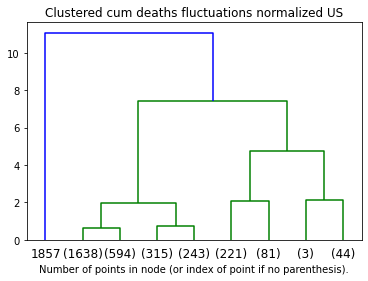

In [424]:
x = deathsD.to_numpy()
deaths_model = AgglomerativeClustering(n_clusters=None, distance_threshold=3)
deaths_model = deaths_model.fit(x)

plt.title('Clustered cum deaths fluctuations normalized US')
# plot the top three levels of the dendrogram
plot_dendrogram(deaths_model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

deaths_model = AgglomerativeClustering(n_clusters=10).fit(x)

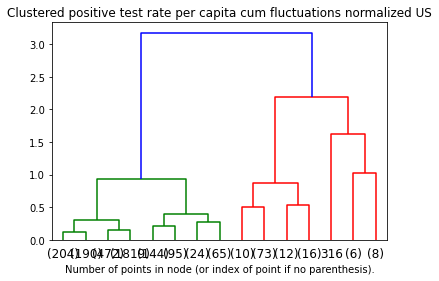

In [425]:
testingD = testingD.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
x = testingD.to_numpy()
testing_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0.9)
testing_model = testing_model.fit(x)

plt.title('Clustered positive test rate per capita cum fluctuations normalized US')
# plot the top three levels of the dendrogram
plot_dendrogram(testing_model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

testing_model = AgglomerativeClustering(n_clusters=10).fit(x)

CUMULATIVE FATALITIES


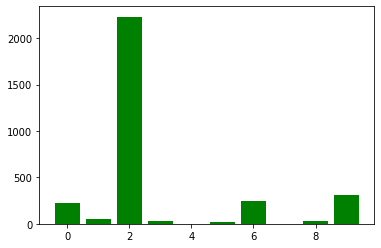

In [426]:
print("CUMULATIVE FATALITIES")
deaths_clt= cluster_counties(deaths_model, deathsD)

CUMULATIVE CASE COUNT CLUSTERS


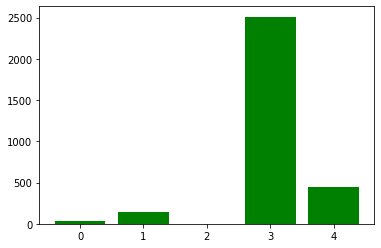

In [437]:
print("CUMULATIVE CASE COUNT CLUSTERS")
cfm_clt =  cluster_counties(cfm_model, confirmedD)

POSITIVE TEST RATE PER CAPITA CLUSTERS


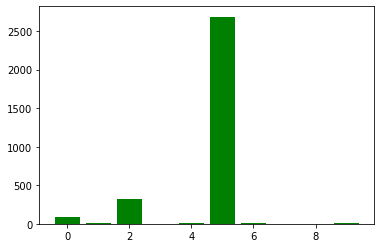

In [428]:
print("POSITIVE TEST RATE PER CAPITA CLUSTERS")
test_clt = cluster_counties(testing_model, testingD)

# Cluster Analysis

Once clustering has been accomplished, 

1. Classify risk spots by county criteria such as maximum or average daily case change 

2. Assign a severity scale (COVID Morbidity and COVID Mortality) to confirmed cases and deaths respectively. 

3. Using a scale of 1 to 10, divide confirmed cases and fatalities into 10 clusters. 

4. This arrangement starting from the county cluster with highest average cumulative mortality/morbidity and lowest average cumulative mortality/morbidity, and second highest (lowest) cluster is the county clusters with minimum average distance between clusters.
 - Thus assuming a radial heatmap from 'hotspots' and 'coldspots'

 5. Scores are allocated to counties based on their distance between the nearest cold and hot spot

## Confirmed Cases

In [438]:
from plotly import figure_factory as ff
import json
def get_lat_long(fips):
  return list(LOC[int(fips)].values())

all_fips = []
all_items = []

for k, v in cfm_clt.items():
  items =  [(str(i), k) for i in v]
  all_items = all_items + items

cfm_clusters = pd.DataFrame(all_items, columns = ["FIPS", "Cluster"])

confirmed.head()

FIPS  population  2020-01-22  ...  2020-05-26  2020-05-27  2020-05-28
0  1001       55200         0.0  ...    0.342391    0.347826    0.371377
1  1003      208107         0.0  ...    0.133105    0.135507    0.135027
2  1005       25782         0.0  ...    0.473198    0.504228    0.511985
3  1007       22527         0.0  ...    0.292982    0.315177    0.315177
4  1009       57645         0.0  ...    0.088473    0.091942    0.100616

[5 rows x 130 columns]

In [439]:

latest_date_cases = confirmed[["FIPS",confirmed.columns[-1]]]
latest_date_cases = pd.DataFrame(latest_date_cases).rename({"FIPS":"FIPS"})
cfm_clusters2 = cfm_clusters.rename({"FIPS": "FIPS"})

latest_date_cases["FIPS"] = latest_date_cases["FIPS"].astype(str)
cfm_clusters2["FIPS"] = cfm_clusters2["FIPS"].astype(str)

cfm_clusters2 = cfm_clusters2.set_index("FIPS")
latest_date_cases = latest_date_cases.set_index("FIPS")

cluster_finaldate = pd.merge( cfm_clusters2, latest_date_cases, left_index=True, right_index=True)
print(cluster_finaldate)

cluster_finaldate["Cluster"] = cluster_finaldate["Cluster"].astype(int)

date = cluster_finaldate.columns[-1]

mean_cases_per_cluster = {}
for c in list(range(cfm_model.n_clusters)):
  temp = cluster_finaldate[cluster_finaldate.Cluster == c]
  mean_cases_per_cluster[c] = round(temp[date].mean(),2)

cluster_assignment = dict(sorted(mean_cases_per_cluster.items(), key=lambda x:x[1], reverse=True))
cluster_assignment = dict([(k, len(cluster_assignment) - list(cluster_assignment.keys()).index(k)) for k,v in cluster_assignment.items()])

cfm_clusters['Cluster'] = cfm_clusters['Cluster'].apply(lambda x: cluster_assignment[int(x)])


      Cluster  2020-05-28
FIPS                     
5079        0    7.119387
13099       0    2.299961
13243       0    2.497531
13273       0    2.404335
16013       0    2.327908
...       ...         ...
55059       4    0.646349
55079       4    0.728562
55101       4    0.821400
56013       4    0.651263
56039       4    0.433670

[3140 rows x 2 columns]


In [0]:
# from plotly import figure_factory as ff
# import json
# from tqdm import tqdm

# def make_dat_cake(x_df=confirmedD):
#   import branca
#   import branca.colormap as cm
#   prev_date = '2020-01-21'
#   multipoint_features = []
#   colormap = cm.linear.YlOrRd_09.scale(1, 10)
#   colormap.caption = "Ordered cluster number, (ascending) intracluster mean confirmed cases per capita"
#   url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data' #For map overlay
#   county_data = f'{url}/us_county_data.csv'
#   county_geo = f'{url}/us_counties_20m_topo.json'

#   all_dates = x_df.columns.to_list()
#   clusters_w_date = 0
#   num_dates = len(all_dates)

#   for i in tqdm(range(num_dates)):
#     current_df = x_df.iloc[0:, 0:i+1]
#     current_x = current_df.to_numpy()
#     model = AgglomerativeClustering(n_clusters=10).fit(current_x)
#     clusters = cluster_counties(model, x_df)
#     all_fips = []
#     all_items = []

#     for k, v in clusters.items():
#       items =  [(str(i), k) for i in v]
#       all_items = all_items + items
#     curr_clusters = pd.DataFrame(all_items, columns = ["FIPS", "Cluster"])
#     curr_clusters_w_name = curr_clusters
#     curr_clusters_w_name = curr_clusters_w_name.set_index("FIPS")
    
#     curr_clusters.index = curr_clusters.index.map(str)
#     current_df.index = current_df.index.map(str)
#     curr_clusters_w_name = pd.merge(curr_clusters_w_name, current_df, left_index=True, right_index=True)
#     curr_clusters_latest = curr_clusters_w_name.sort_values("Cluster", ascending=False)
#     latest = current_df.columns[-1]

#     curr_clusters_latest["Cluster"] = curr_clusters_latest["Cluster"].astype(int)
#     date = curr_clusters_latest.columns[-1]
#     mean_cases_per_curr_cluster = {}
#     for c in list(range(10)):
#       temp = curr_clusters_latest[curr_clusters_latest.Cluster == c]
#       mean_cases_per_curr_cluster[c] = round(temp[date].mean(),10)
#     curr_cluster_assignment = dict(sorted(mean_cases_per_curr_cluster.items(), key=lambda x:x[1], reverse=True))
#     curr_cluster_assignment = dict([(k, len(curr_cluster_assignment) - list(curr_cluster_assignment.keys()).index(k)) for k,v in curr_cluster_assignment.items()])
    
#     curr_clusters_latest['Cluster'] = curr_clusters_latest['Cluster'].apply(lambda x: curr_cluster_assignment[int(x)])
#     top_counties = curr_clusters_latest.nlargest(10, columns=curr_clusters_latest.columns[-1])
#     ele = {"coordinates":[get_lat_long(fip) for fip in top_counties.index.to_list()], "date":[date, prev_date]}
#     multipoint_features.append(ele)
#     prev_date = date
#   return multipoint_features

# mp_features = make_dat_cake()

In [0]:
# features = [
#           {   'type': 'Feature',
#               'geometry': {
#                  'type': 'MultiPoint',
#                  'coordinates': f['coordinates'],
#               }, 
#               'properties': {
#                   'times':f['date'], 
#                   'style':{
#                       'color': "#black",
#                       'weight': 1000
#                   }
#               }
#              }
#             for f in mp_features]

# print(features)

In [440]:
cfm_clusters_w_name = cfm_clusters
cfm_clusters_w_name["County"] = cfm_clusters["FIPS"].apply(lambda x: LU[int(x)]["Combined_Key"])
cfm_clusters_w_name = cfm_clusters_w_name.set_index("FIPS")
cfm_clusters_w_name = pd.merge(cfm_clusters_w_name, latest_date_cases, right_index=True, left_index=True)
cfm_clusters_w_name = cfm_clusters_w_name.sort_values("Cluster", ascending=False)

latest = cfm_clusters_w_name.columns[-1]
cfm_clusters_w_name[latest] = cfm_clusters_w_name[latest].apply(lambda x: round(x,2))


cfm_clusters_w_name.to_csv("/content/clusters_by_confirmed_cases.csv")
cfm_clusters_w_name.head()

Cluster                       County  2020-05-28
FIPS                                                   
36061        5  New York City, New York, US       12.32
47169        5     Trousdale, Tennessee, US       14.55
5079         4        Lincoln, Arkansas, US        7.12
39101        4             Marion, Ohio, US        4.04
36059        4         Nassau, New York, US        2.96

In [443]:
import branca
import branca.colormap as cm
colormap = cm.linear.YlOrRd_09.scale(1, cfm_model.n_clusters)
colormap.caption = "Ordered cluster number, (ascending) intracluster mean confirmed cases per capita"

top_counties = cfm_clusters_w_name.nlargest(10, columns=cfm_clusters_w_name.columns[-1])
print(top_counties.loc['47169'][-1])

latest_date = confirmed.columns[-1]
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data' #For map overlay
county_data = f'{url}/us_county_data.csv'
county_geo = f'{url}/us_counties_20m_topo.json'

colorscale = colormap
cfm_clusters_series = cfm_clusters.set_index('FIPS')

def style_function(feature):
    try:
      cluster_num = cfm_clusters_series.loc[str(int(feature["id"][-5:])), :]["Cluster"]
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor':  colorscale(cluster_num)
    }
    except KeyError:
      cluster_num = None
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black'
    }
    
m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=5
)

folium.TopoJson(
    json.loads(requests.get(county_geo).text),
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)

m

14.55


In [0]:
confirmedD.shape[1]

In [0]:
# import branca
# import branca.colormap as cm
# colormap = cm.linear.YlOrRd_09.scale(1, 10)
# colormap.caption = "Ordered cluster number, (ascending) intracluster mean confirmed cases per capita"

# def get_lat_long(fips):
#   return list(LOC[int(fips)].values())

# multipoint_features = []

# top_fips = []
# for i in range(confirmedD.shape[1]):
#   top_fips.append(confirmedD.nlargest(10, columns=cfm_clusters_w_name.columns[-1]).index.to_list().map(get_lat_long))

# print(top_fips)

# latest_date = confirmed.columns[-1]
# url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data' #For map overlay
# county_data = f'{url}/us_county_data.csv'
# county_geo = f'{url}/us_counties_20m_topo.json'

# colorscale = branca.colormap.linear.YlOrRd_09.scale(1, 10)
# cfm_clusters_series = cfm_clusters.set_index('FIPS')

# def style_function(feature):
#     try:
#        cluster_num = cfm_clusters_series.loc[str(int(feature["id"][-5:])), :]["Cluster"]
#        return {
#          'fillOpacity': 0.5,
#          'weight': 0,
#          'fillColor':  colorscale(cluster_num)
#      }
#     except KeyError:
#        cluster_num = None
#        return {
#          'fillOpacity': 0.5,
#          'weight': 0,
#          'fillColor': '#black'
#      }
    

# m = folium.Map(
#     location=[48, -102],
#     tiles='cartodbpositron',
#      zoom_start=2
#  )

# multipoint_features = [
#   {"coordinates":[get_lat_long(f) for f in top_counties], "dates": [d]} for d in all_da
# ]

# for fip in list(top5_counties.index):
#    folium.Marker(
#        get_lat_long(fip),
#        popup = "{}: {} %".format(top_counties.loc[fip]['County'], top_counties.loc[fip][-1])
#    ).add_to(m)

# folium.TopoJson(
#      json.loads(requests.get(county_geo).text),
#      'objects.us_counties_20m',
#      style_function=style_function
#       ).add_to(m)

From here, we deduce that Cluster 2 is a 'coldspot' in terms of confirmed cases in the US while Clusters 6,4,2,9,8,0 might have 'hotspots' (we will discern one with other factors).

In [445]:
print(latest_date_cases)

       2020-05-28
FIPS             
1001     0.371377
1003     0.135027
1005     0.511985
1007     0.315177
1009     0.100616
...           ...
56037    0.058934
56039    0.433670
56041    0.058227
56043    0.430557
56045    0.014085

[3140 rows x 1 columns]


From here, we deduce that Cluster 2 is a 'coldspot' in terms of fatality cases in the US while Clusters 3,8,6,4 might be 'hotspots' (we will discern one with other factors).

## Fatality Cases

In [0]:
from plotly import figure_factory as ff
import json


all_fips = []
all_items = []

for k, v in deaths_clt.items():
  items =  [(str(i), k) for i in v]
  all_items = all_items + items

deaths_clusters = pd.DataFrame(all_items, columns = ["FIPS", "Cluster"])

deaths_clusters.head()

FIPS Cluster
0  1013       0
1  1063       0
2  1093       0
3  1111       0
4  1119       0

In [0]:
# topo = json.loads(requests.get(county_geo).text)
# cfm_clusters_series = cfm_clusters.set_index('FIPS')

latest_date_deaths = deaths[["FIPS",confirmed.columns[-1]]]
latest_date_deaths = pd.DataFrame(latest_date_deaths).rename({"FIPS":"FIPS"})
deaths_clusters2 = deaths_clusters.rename({"FIPS": "FIPS"})

latest_date_deaths["FIPS"] = latest_date_deaths["FIPS"].astype(str)
deaths_clusters2["FIPS"] = deaths_clusters2["FIPS"].astype(str)

deaths_clusters2 = deaths_clusters2.set_index("FIPS")
latest_date_deaths = latest_date_deaths.set_index("FIPS")

deaths_finaldate = pd.merge( deaths_clusters2, latest_date_deaths, left_index=True, right_index=True)
print(cluster_finaldate)

deaths_finaldate["Cluster"] = deaths_finaldate["Cluster"].astype(int)

date = deaths_finaldate.columns[-1]

mean_deaths_per_cluster = {}
for c in list(range(10)):
  temp = deaths_finaldate[deaths_finaldate.Cluster == c]
  mean_deaths_per_cluster[c] = round(temp[date].mean(),2)

cluster_assignment = dict(sorted(mean_deaths_per_cluster.items(), key=lambda x:x[1], reverse=True))
cluster_assignment = dict([(k, len(cluster_assignment) - list(cluster_assignment.keys()).index(k)) for k,v in cluster_assignment.items()])
print(cluster_assignment)

deaths_clusters['Cluster'] = deaths_clusters['Cluster'].apply(lambda x: cluster_assignment[int(x)])

print(deaths_clusters)

       Cluster  2020-05-28
FIPS                      
1013         0    1.957553
1085         0    2.168816
4001         0    1.803641
5123         0    2.510078
8075         0    2.697220
...        ...         ...
55127        9    0.361119
56009        9    0.171465
56019        9    0.211392
56021        9    0.192442
56043        9    0.430557

[3140 rows x 2 columns]
{7: 10, 4: 9, 5: 8, 3: 7, 8: 6, 1: 5, 0: 4, 6: 3, 9: 2, 2: 1}
       FIPS  Cluster
0      1013        4
1      1063        4
2      1093        4
3      1111        4
4      1119        4
...     ...      ...
3135  55059        2
3136  55101        2
3137  55105        2
3138  55127        2
3139  56019        2

[3140 rows x 2 columns]


In [0]:
deaths_clusters_w_name = deaths_clusters
deaths_clusters_w_name["County"] = deaths_clusters["FIPS"].apply(lambda x: LU[int(x)]["Combined_Key"])
deaths_clusters_w_name = deaths_clusters_w_name.set_index("FIPS")
deaths_clusters_w_name = pd.merge(deaths_clusters_w_name, latest_date_deaths, right_index=True, left_index=True)
deaths_clusters_w_name = deaths_clusters_w_name.sort_values("Cluster", ascending=False)


latest = deaths_clusters_w_name.columns[-1]
deaths_clusters_w_name[latest] = deaths_clusters_w_name[latest].apply(lambda x: round(x,5))


deaths_clusters_w_name.to_csv("/content/clusters_by_fatalities.csv")
deaths_clusters_w_name.head()

Cluster                       County  2020-05-28
FIPS                                                   
36061       10  New York City, New York, US     1.31181
13099        9           Early, Georgia, US     0.28991
13243        9        Randolph, Georgia, US     0.26810
13273        9         Terrell, Georgia, US     0.29349
13095        8       Dougherty, Georgia, US     0.15816

In [0]:
import branca
import branca.colormap as cm
colormap = cm.linear.YlGn_09.scale(1,10)
colormap.caption = "Ordered cluster number, (ascending) intracluster mean fatalities per capita"

top_counties = deaths_clusters_w_name.nlargest(10, columns=deaths_clusters_w_name.columns[-1])
latest_date = deaths.columns[-1]
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data' #For map overlay
county_data = f'{url}/us_county_data.csv'
county_geo = f'{url}/us_counties_20m_topo.json'

colorscale = colormap
deaths_clusters_series = deaths_clusters.set_index('FIPS')


def style_function(feature):
    try:
      cluster_num = deaths_clusters_series.loc[str(int(feature["id"][-5:])), :]["Cluster"]
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor':  colorscale(cluster_num)
    }
    except KeyError:
      cluster_num = None
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black'
    }

NY_latlong = [40.7128, 74.0060]

m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=5
)

for fip in list(top_counties.index):
  folium.Marker(
      get_lat_long(fip),
      popup = "{}: {} %".format(top_counties.loc[fip]['County'], top_counties.loc[fip][-1])
  ).add_to(m)

folium.TopoJson(
    json.loads(requests.get(county_geo).text),
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)

m.add_child(colormap)

m.save("deaths_map.html")
m

## Testing 

In [0]:
from plotly import figure_factory as ff
import json


all_fips = []
all_items = []

for k, v in test_clt.items():
  items =  [(str(i), k) for i in v]
  all_items = all_items + items

testing_clusters = pd.DataFrame(all_items, columns = ["FIPS", "Cluster"])

testing_clusters.head()

FIPS Cluster
0  2020       0
1  4019       0
2  8001       0
3  8005       0
4  8013       0

In [0]:
# topo = json.loads(requests.get(county_geo).text)
# cfm_clusters_series = cfm_clusters.set_index('FIPS')

latest_date_testing = testing[["FIPS",confirmed.columns[-1]]]
latest_date_testing = pd.DataFrame(latest_date_testing).rename({"FIPS":"FIPS"})
testing_clusters2 = testing_clusters.rename({"FIPS": "FIPS"})

latest_date_testing["FIPS"] = latest_date_testing["FIPS"].astype(str)
testing_clusters2["FIPS"] = testing_clusters2["FIPS"].astype(str)

testing_clusters2 = testing_clusters2.set_index("FIPS")
latest_date_testing = latest_date_testing.set_index("FIPS")

testing_finaldate = pd.merge( testing_clusters2, latest_date_testing, left_index=True, right_index=True)
print(cluster_finaldate)

testing_finaldate["Cluster"] = testing_finaldate["Cluster"].astype(int)

date = testing_finaldate.columns[-1]

mean_testing_per_cluster = {}
for c in list(range(10)):
  temp = testing_finaldate[testing_finaldate.Cluster == c]
  mean_testing_per_cluster[c] = round(temp[date].mean(),2)

cluster_assignment = dict(sorted(mean_testing_per_cluster.items(), key=lambda x:x[1], reverse=True))
cluster_assignment = dict([(k, len(cluster_assignment) - list(cluster_assignment.keys()).index(k)) for k,v in cluster_assignment.items()])
print(cluster_assignment)

testing_clusters['Cluster'] = testing_clusters['Cluster'].apply(lambda x: cluster_assignment[int(x)])
testing_finaldate['Cluster'] = testing_finaldate['Cluster'].apply(lambda x: cluster_assignment[int(x)])
print(testing_clusters)

       Cluster  2020-05-28
FIPS                      
1013         0    1.957553
1085         0    2.168816
4001         0    1.803641
5123         0    2.510078
8075         0    2.697220
...        ...         ...
55127        9    0.361119
56009        9    0.171465
56019        9    0.211392
56021        9    0.192442
56043        9    0.430557

[3140 rows x 2 columns]
{7: 10, 8: 9, 9: 8, 1: 7, 3: 6, 6: 5, 0: 4, 4: 3, 2: 2, 5: 1}
       FIPS  Cluster
0      2020        4
1      4019        4
2      8001        4
3      8005        4
4      8013        4
...     ...      ...
3134   9003        8
3135   9009        8
3136  17031        8
3137  32003        8
3138  44007        8

[3139 rows x 2 columns]


In [0]:
import branca
import branca.colormap as cm
# colormap = cm.linear.RdGy_11.scale(1,10)
colormap = cm.LinearColormap(['blue', 'white', 'red'], vmin=1, vmax=10)
colormap.caption = "Ordered cluster number, (ascending) intracluster mean positive testing rate"

latest_date = confirmed.columns[-1]
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data' #For map overlay
county_data = f'{url}/us_county_data.csv'
county_geo = f'{url}/us_counties_20m_topo.json'


colorscale = colormap
testing_clusters_series = testing_clusters.set_index('FIPS')


def style_function(feature):
    try:
      cluster_num = testing_clusters_series.loc[str(int(feature["id"][-5:])), :]["Cluster"]
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor':  colorscale(cluster_num)
    }
    except KeyError:
      cluster_num = None
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black'
    }
    

m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=2
)

folium.TopoJson(
    json.loads(requests.get(county_geo).text),
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)

m.add_child(colormap)

m

In [0]:
testing_finaldate

Cluster  2020-05-28
FIPS                      
2020         4    0.003592
4019         4    0.012850
8001         4    0.013646
8005         4    0.017477
8013         4    0.008812
...        ...         ...
9003         8    0.044081
9009         8    0.042338
17031        8    0.056861
32003        8    0.045842
44007        8    0.062011

[3139 rows x 2 columns]

In [0]:
testing_clusters_w_name = testing_clusters
testing_clusters_w_name["County"] = testing_clusters["FIPS"].apply(lambda x: LU[int(x)])
testing_clusters_w_name = testing_clusters_w_name.set_index("FIPS")
testing_clusters_w_name = pd.merge(testing_clusters_w_name, latest_date_deaths, right_index=True, left_index=True)
testing_clusters_w_name = testing_clusters_w_name.sort_values("Cluster", ascending=False)

latest = testing_clusters_w_name.columns[-1]
testing_clusters_w_name[latest] = testing_clusters_w_name[latest].apply(lambda x: round(x,5))

testing_clusters_w_name.head()
testing_clusters_w_name.to_csv("/content/clusters_by_ptr.csv")

## Extra Case: Average Mobility (Walking, Transit, Driving)

In [0]:
mobility_US = pd.read_csv("/content/spaceapps/applemobilitydata/applemobilitycleaned_county.csv").drop(columns=["region", "sub-region", "Unnamed: 0"])
mobility_US = mobility_US.dropna()
mobility_US["fips"] =  mobility_US["fips"].astype('int')
mobility_US = mobility_US.rename(columns={"fips":"FIPS"}).set_index("FIPS")

mobility_US.head()

2020-01-13  2020-01-14  2020-01-15  ...  2020-05-25  2020-05-26  2020-05-27
FIPS                                       ...                                    
45001       100.0      110.87  112.130000  ...      136.75  156.870000      163.88
22001       100.0      115.17  120.940000  ...      128.49  153.800000      171.17
51001       100.0       98.93   99.530000  ...      180.18  168.340000      143.20
16001       100.0       99.89  105.050000  ...      108.77  137.700000      142.89
19001       100.0       98.30   98.626667  ...      136.91  129.006667      126.89

[5 rows x 134 columns]

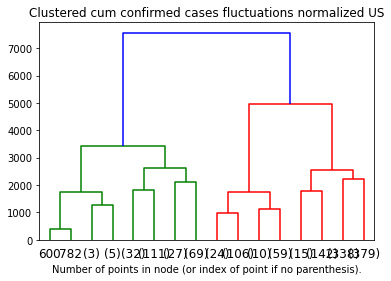

In [0]:
x = mobility_US.to_numpy()
mob_model = AgglomerativeClustering(n_clusters=None, distance_threshold=10)
mob_model = mob_model.fit(x)


plt.title('Clustered cum confirmed cases fluctuations normalized US')
plot_dendrogram(mob_model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

mob_model = AgglomerativeClustering(n_clusters=10).fit(x)


In [0]:
mobility_US.head()

2020-01-13  2020-01-14  2020-01-15  ...  2020-05-25  2020-05-26  2020-05-27
FIPS                                       ...                                    
45001       100.0      110.87  112.130000  ...      136.75  156.870000      163.88
22001       100.0      115.17  120.940000  ...      128.49  153.800000      171.17
51001       100.0       98.93   99.530000  ...      180.18  168.340000      143.20
16001       100.0       99.89  105.050000  ...      108.77  137.700000      142.89
19001       100.0       98.30   98.626667  ...      136.91  129.006667      126.89

[5 rows x 134 columns]

In [0]:
print("CUMULATIVE CASE COUNT CLUSTERS")
mob_clt =  cluster_counties(mob_model, mobility_US)

In [0]:
temp = []

for k, v in mob_clt.items():
  v = v.dropna()
  v = v.astype(int)
  temp.append((k,v))

mob_clt = dict(temp)

mob_clt

In [0]:
from plotly import figure_factory as ff
import json

all_fips = []
all_items = []

for k, v in mob_clt.items():
  items =  [(str(i), k) for i in v]
  all_items = all_items + items

mob_clusters = pd.DataFrame(all_items, columns = ["FIPS", "Cluster"])

mob_clusters.head()

In [0]:
mob_clusters2 = mob_clusters
latest_date_mobilties = mobility_US[[mobility_US.columns[-1]]]
latest_date_mobilties = pd.DataFrame(latest_date_mobilties)

cluster_finaldate = pd.merge( mob_clusters2, latest_date_mobilties, left_index=True, right_index=True)
print(cluster_finaldate)

cluster_finaldate["Cluster"] = cluster_finaldate["Cluster"].astype(int)

date = cluster_finaldate.columns[-1]

mean_mobility_per_cluster = {}
for c in list(range(10)):
  temp = cluster_finaldate[cluster_finaldate.Cluster == c]
  mean_mobility_per_cluster[c] = round(temp[date].mean(),2)

cluster_assignment = dict(sorted(mean_mobility_per_cluster.items(), key=lambda x:x[1], reverse=True))
cluster_assignment = dict([(k, len(cluster_assignment) - list(cluster_assignment.keys()).index(k)) for k,v in cluster_assignment.items()])
print(cluster_assignment)

mob_clusters['Cluster'] = mob_clusters['Cluster'].apply(lambda x: cluster_assignment[int(x)])

print(mob_clusters)

In [0]:
import branca
import branca.colormap as cm
colormap = cm.linear.YlGn_09.scale(1,10)
colormap.caption = "Ordered cluster number, intracluster mean mobility (transit, cycling, walking)"

latest_date = mobility_US.columns[-1]
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data' #For map overlay
county_data = f'{url}/us_county_data.csv'
county_geo = f'{url}/us_counties_20m_topo.json'


colorscale = colormap
def style_function(feature):
    print()
    try:
      mapping_value= mob_clusters_series.loc[str(int(feature["id"][-5:])), :]["Cluster"]
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor':  colorscale(mapping_value)
    }
    except KeyError:
      mapping_value = None
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black'
    }
    

m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=2
)


folium.TopoJson(
    json.loads(requests.get(county_geo).text),
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)

m.add_child(colormap)

## Extra Case: Predicted Cases


In [0]:
from plotly import figure_factory as ff
import json

predictions = pd.read_csv("/content/spaceapps/predictions/county_prediction_mapping.csv")
print(predictions.columns.to_list())
predictions = predictions.drop(columns=["Unnamed: 0"])
print(type(predictions["fips"][0]))
predictions["County"] = predictions["fips"].apply(lambda x: LU[x]["Combined_Key"])
predictions = predictions.set_index("fips")
predictions.head()


['Unnamed: 0', 'fips', 'mapping']
<class 'numpy.int64'>


mapping                County
fips                                
1001  0.110773  Autauga, Alabama, US
1003  0.086488  Baldwin, Alabama, US
1005  0.078578  Barbour, Alabama, US
1007  0.043328     Bibb, Alabama, US
1009  0.000006   Blount, Alabama, US

In [0]:
# colormap = cm.linear.GnBu_03.scale(-1,1)
colormap = cm.LinearColormap(['green', 'white', 'red'], vmin=-1, vmax=1)
colormap.caption = "Predictions"

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data' #For map overlay
county_data = f'{url}/us_county_data.csv'
county_geo = f'{url}/us_counties_20m_topo.json'

top_counties = predictions.nlargest(10, columns='mapping')

colorscale = colormap

def style_function(feature):
    
    try:
      cluster_num = predictions.loc[int(feature["id"][-5:]), :]["mapping"]
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor':  colorscale(cluster_num)
    }
    except KeyError:
      cluster_num = None
      return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': 'white'
    }
    

m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=5
)

for fip in list(top_counties.index):
  folium.Marker(
      get_lat_long(fip),
      popup = "{}: {}".format(FIPS_to_name(fip, LU), top_counties.loc[fip][-1])
  ).add_to(m)

folium.TopoJson(
    json.loads(requests.get(county_geo).text),
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)

m.add_child(colormap)

m.save("7daypreds.html")

In [0]:
top_counties.to_csv("AtRiskCounties_7DayPredictions.csv")